# Kelly Criterion Position Sizing Analysis

Explore optimal position sizing using Kelly criterion and variants.

## Goals
1. Implement Kelly criterion for straddle sizing
2. Compare fixed vs Kelly vs fractional Kelly sizing
3. Analyze impact on returns, drawdowns, and Sharpe
4. Find practical position sizing rules

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('../data/earnings')

# Load OOS predictions
oos = pd.read_parquet(DATA_DIR / 'oos_predictions.parquet')
oos['earnings_date'] = pd.to_datetime(oos['earnings_date'])

print(f"Loaded {len(oos)} predictions")
print(f"Date range: {oos['earnings_date'].min().date()} to {oos['earnings_date'].max().date()}")

Loaded 60257 predictions
Date range: 2022-01-10 to 2025-12-18


## 1. Kelly Criterion Background

The Kelly criterion maximizes long-term growth rate:

$$f^* = \frac{p \cdot b - q}{b} = \frac{p(b+1) - 1}{b}$$

Where:
- $f^*$ = fraction of bankroll to bet
- $p$ = probability of winning
- $q$ = probability of losing (1-p)
- $b$ = odds (win amount / loss amount)

For straddles, this is more complex because:
1. P&L is continuous, not binary
2. Max loss is known (premium paid)
3. Win size depends on move magnitude

We'll use a simplified approach based on expected edge and variance.

In [2]:
def compute_kelly_fraction(expected_return, variance, max_fraction=0.25):
    """
    Compute Kelly fraction for continuous returns.
    
    For normally distributed returns:
    f* = mu / sigma^2
    
    Args:
        expected_return: Expected return (e.g., 0.05 for 5%)
        variance: Variance of returns
        max_fraction: Cap on Kelly fraction (safety limit)
    
    Returns:
        Optimal fraction of bankroll to risk
    """
    if variance <= 0 or expected_return <= 0:
        return 0.0
    
    kelly = expected_return / variance
    return min(kelly, max_fraction)


def compute_edge_based_kelly(pred_q75, implied_move, spread_cost=0.03, 
                              historical_std=0.10, kelly_mult=0.5):
    """
    Compute Kelly-like sizing based on predicted edge.
    
    The continuous Kelly formula is: f* = edge / variance
    
    For our trades with ~12% std and ~7% edge:
    - Raw Kelly = 0.07 / 0.0144 = 4.86 (bet 486% of wealth - way too aggressive)
    - Half Kelly = 2.43
    - Quarter Kelly = 1.21
    
    We convert this to a practical multiplier by dividing by 2:
    - Half Kelly at 7% edge → multiplier ~1.2
    - Quarter Kelly at 7% edge → multiplier ~0.6
    - Half Kelly at 12% edge → multiplier ~2.1
    
    Args:
        pred_q75: Model's q75 prediction
        implied_move: Options implied move (cost)
        spread_cost: Spread cost as fraction
        historical_std: Historical std of P&L for similar trades
        kelly_mult: Fractional Kelly multiplier (0.5 = half Kelly, 0.25 = quarter)
    
    Returns:
        Position size multiplier (1.0 = base size)
    """
    edge = pred_q75 - implied_move - spread_cost
    
    if edge <= 0:
        return 0.0
    
    # Raw Kelly: fraction of wealth to bet
    variance = historical_std ** 2
    raw_kelly = edge / variance
    
    # Apply fractional Kelly (half = 0.5, quarter = 0.25)
    fractional_kelly = raw_kelly * kelly_mult
    
    # Convert to practical multiplier
    # Divide by 2 so that fractional_kelly of ~2 → multiplier of ~1
    # This gives sensible scaling:
    #   - 7% edge, half kelly: raw=4.86, frac=2.43, mult=1.2
    #   - 7% edge, quarter kelly: raw=4.86, frac=1.21, mult=0.6
    #   - 12% edge, half kelly: raw=8.33, frac=4.17, mult=2.1
    multiplier = fractional_kelly / 2.0
    
    # Cap between 0.5x and 3x base size
    return np.clip(multiplier, 0.5, 3.0)


# Quick sanity check
print("Kelly multiplier sanity check:")
print(f"  7% edge, Half Kelly:    {compute_edge_based_kelly(0.14, 0.07, 0.03, 0.12, 0.5):.2f}x")
print(f"  7% edge, Quarter Kelly: {compute_edge_based_kelly(0.14, 0.07, 0.03, 0.12, 0.25):.2f}x")
print(f"  10% edge, Half Kelly:   {compute_edge_based_kelly(0.17, 0.07, 0.03, 0.12, 0.5):.2f}x")
print(f"  10% edge, Quarter Kelly:{compute_edge_based_kelly(0.17, 0.07, 0.03, 0.12, 0.25):.2f}x")
print(f"  15% edge, Half Kelly:   {compute_edge_based_kelly(0.22, 0.07, 0.03, 0.12, 0.5):.2f}x")
print(f"  15% edge, Quarter Kelly:{compute_edge_based_kelly(0.22, 0.07, 0.03, 0.12, 0.25):.2f}x")

Kelly multiplier sanity check:
  7% edge, Half Kelly:    0.69x
  7% edge, Quarter Kelly: 0.50x
  10% edge, Half Kelly:   1.22x
  10% edge, Quarter Kelly:0.61x
  15% edge, Half Kelly:   2.08x
  15% edge, Quarter Kelly:1.04x


## 2. Prepare Trade Data

In [3]:
# Compute implied move and edge (using 1.3x realistic multiplier)
IMPLIED_MULT = 1.3
SPREAD_COST = 0.03
COMMISSION_PCT = 0.001  # ~0.1% for commissions

df = oos.copy()
df['implied_move'] = df['hist_move_mean'] * IMPLIED_MULT
df['edge'] = df['pred_q75'] - df['implied_move']
df['total_cost'] = df['implied_move'] + SPREAD_COST + COMMISSION_PCT
df['pnl'] = df['target_move'] - df['total_cost']

print(f"Overall stats:")
print(f"  Mean edge: {df['edge'].mean():.2%}")
print(f"  Mean P&L: {df['pnl'].mean():.2%}")
print(f"  P&L std: {df['pnl'].std():.2%}")
print(f"  Win rate: {(df['pnl'] > 0).mean():.1%}")

Overall stats:
  Mean edge: 0.65%
  Mean P&L: -4.32%
  P&L std: 8.09%
  Win rate: 18.5%


In [4]:
# Filter to tradeable candidates (positive edge)
EDGE_THRESHOLD = 0.06  # 6% minimum edge

trades = df[df['edge'] > EDGE_THRESHOLD].copy()
trades = trades.sort_values('earnings_date')

print(f"Tradeable candidates: {len(trades)} ({len(trades)/len(df)*100:.1f}%)")
print(f"  Mean edge: {trades['edge'].mean():.2%}")
print(f"  Mean P&L: {trades['pnl'].mean():.2%}")
print(f"  P&L std: {trades['pnl'].std():.2%}")
print(f"  Win rate: {(trades['pnl'] > 0).mean():.1%}")

Tradeable candidates: 1188 (2.0%)
  Mean edge: 7.38%
  Mean P&L: 1.01%
  P&L std: 10.22%
  Win rate: 41.8%


## 3. Position Sizing Strategies

In [5]:
def simulate_sizing_strategy(trades_df, sizing_func, initial_bankroll=100000,
                             base_risk_pct=0.02, max_daily_trades=5):
    """
    Simulate trading with a position sizing strategy.
    
    Args:
        trades_df: DataFrame with trade candidates
        sizing_func: Function(row, bankroll) -> position_size_dollars
        initial_bankroll: Starting capital
        base_risk_pct: Base risk per trade as % of bankroll
        max_daily_trades: Max trades per day
    
    Returns:
        DataFrame with trade results and running bankroll
    """
    results = []
    bankroll = initial_bankroll
    
    # Sort by date and edge
    df = trades_df.sort_values(['earnings_date', 'edge'], ascending=[True, False]).copy()
    
    # Track daily trade count
    daily_counts = {}
    
    for idx, row in df.iterrows():
        date = row['earnings_date'].date()
        
        # Check daily limit
        if daily_counts.get(date, 0) >= max_daily_trades:
            continue
        
        # Get position size
        position_size = sizing_func(row, bankroll, base_risk_pct)
        
        if position_size <= 0:
            continue
        
        # Cap at available bankroll
        position_size = min(position_size, bankroll * 0.5)  # Max 50% in one trade
        
        # Compute P&L
        pnl_pct = row['pnl']
        pnl_dollars = position_size * pnl_pct
        
        # Update bankroll
        bankroll += pnl_dollars
        
        # Track
        daily_counts[date] = daily_counts.get(date, 0) + 1
        
        results.append({
            'date': row['earnings_date'],
            'symbol': row['symbol'],
            'edge': row['edge'],
            'pnl_pct': pnl_pct,
            'position_size': position_size,
            'pnl_dollars': pnl_dollars,
            'bankroll': bankroll,
        })
    
    return pd.DataFrame(results)


# Define sizing strategies
def fixed_sizing(row, bankroll, base_risk_pct):
    """Fixed percentage of bankroll."""
    return bankroll * base_risk_pct


def edge_linear_sizing(row, bankroll, base_risk_pct):
    """Scale linearly with edge (simple approach)."""
    edge = row['edge']
    # Scale: 6% edge = 1x, 12% edge = 2x, etc.
    multiplier = edge / 0.06
    multiplier = np.clip(multiplier, 0.5, 3.0)
    return bankroll * base_risk_pct * multiplier


def half_kelly_sizing(row, bankroll, base_risk_pct):
    """Half-Kelly based on edge and historical variance."""
    edge = row['edge']
    
    # Use historical P&L std as proxy for variance
    # (In practice, could use rolling window or segment-specific)
    historical_std = 0.12  # ~12% std from earlier analysis
    
    kelly = compute_edge_based_kelly(
        pred_q75=row['pred_q75'],
        implied_move=row['implied_move'],
        spread_cost=SPREAD_COST,
        historical_std=historical_std,
        kelly_mult=0.5  # Half Kelly
    )
    
    return bankroll * base_risk_pct * kelly


def quarter_kelly_sizing(row, bankroll, base_risk_pct):
    """Quarter-Kelly (more conservative)."""
    edge = row['edge']
    historical_std = 0.12
    
    kelly = compute_edge_based_kelly(
        pred_q75=row['pred_q75'],
        implied_move=row['implied_move'],
        spread_cost=SPREAD_COST,
        historical_std=historical_std,
        kelly_mult=0.25  # Quarter Kelly
    )
    
    return bankroll * base_risk_pct * kelly

## 4. Compare Strategies

In [6]:
# Run simulations
INITIAL_BANKROLL = 100000
BASE_RISK = 0.02  # 2% base risk per trade

strategies = {
    'Fixed (2%)': fixed_sizing,
    'Edge Linear': edge_linear_sizing,
    'Half Kelly': half_kelly_sizing,
    'Quarter Kelly': quarter_kelly_sizing,
}

results = {}
for name, func in strategies.items():
    results[name] = simulate_sizing_strategy(
        trades, func, 
        initial_bankroll=INITIAL_BANKROLL,
        base_risk_pct=BASE_RISK,
        max_daily_trades=5
    )
    print(f"{name}: {len(results[name])} trades")

Fixed (2%): 950 trades
Edge Linear: 950 trades
Half Kelly: 950 trades
Quarter Kelly: 950 trades


In [7]:
# Compute performance metrics
def compute_metrics(result_df, initial_bankroll):
    """Compute key performance metrics."""
    if len(result_df) == 0:
        return {}
    
    final_bankroll = result_df['bankroll'].iloc[-1]
    total_return = (final_bankroll - initial_bankroll) / initial_bankroll
    
    # CAGR
    n_years = (result_df['date'].max() - result_df['date'].min()).days / 365
    cagr = (final_bankroll / initial_bankroll) ** (1/n_years) - 1 if n_years > 0 else 0
    
    # Drawdown
    result_df = result_df.copy()
    result_df['high_water'] = result_df['bankroll'].cummax()
    result_df['drawdown'] = (result_df['bankroll'] - result_df['high_water']) / result_df['high_water']
    max_dd = result_df['drawdown'].min()
    
    # Sharpe (daily)
    daily_returns = result_df.groupby(result_df['date'].dt.date)['pnl_dollars'].sum()
    daily_returns_pct = daily_returns / INITIAL_BANKROLL  # Approximate
    
    n_days = len(daily_returns)
    n_calendar = (result_df['date'].max() - result_df['date'].min()).days
    trades_per_year = n_days * 252 / n_calendar if n_calendar > 0 else 100
    
    sharpe = (daily_returns_pct.mean() / daily_returns_pct.std()) * np.sqrt(trades_per_year) if daily_returns_pct.std() > 0 else 0
    
    # Win rate
    win_rate = (result_df['pnl_dollars'] > 0).mean()
    
    # Average position size
    avg_position = result_df['position_size'].mean()
    avg_position_pct = avg_position / initial_bankroll
    
    return {
        'n_trades': len(result_df),
        'total_return': total_return,
        'cagr': cagr,
        'max_drawdown': max_dd,
        'sharpe': sharpe,
        'win_rate': win_rate,
        'avg_position_pct': avg_position_pct,
        'final_bankroll': final_bankroll,
    }

# Compute for all strategies
metrics = {}
for name, result_df in results.items():
    metrics[name] = compute_metrics(result_df, INITIAL_BANKROLL)

metrics_df = pd.DataFrame(metrics).T
print("=== Strategy Comparison ===")
print(metrics_df.to_string(formatters={
    'total_return': '{:.1%}'.format,
    'cagr': '{:.1%}'.format,
    'max_drawdown': '{:.1%}'.format,
    'sharpe': '{:.2f}'.format,
    'win_rate': '{:.1%}'.format,
    'avg_position_pct': '{:.1%}'.format,
    'final_bankroll': '${:,.0f}'.format,
}))

=== Strategy Comparison ===
               n_trades total_return cagr max_drawdown sharpe win_rate avg_position_pct final_bankroll
Fixed (2%)        950.0        23.8% 5.6%        -3.4%   1.31    43.4%             2.3%       $123,771
Edge Linear       950.0        41.0% 9.2%        -3.7%   1.46    43.4%             3.1%       $141,029
Half Kelly        950.0        28.2% 6.6%        -2.2%   1.56    43.4%             1.8%       $128,185
Quarter Kelly     950.0        14.1% 3.4%        -1.6%   1.45    43.4%             1.1%       $114,096


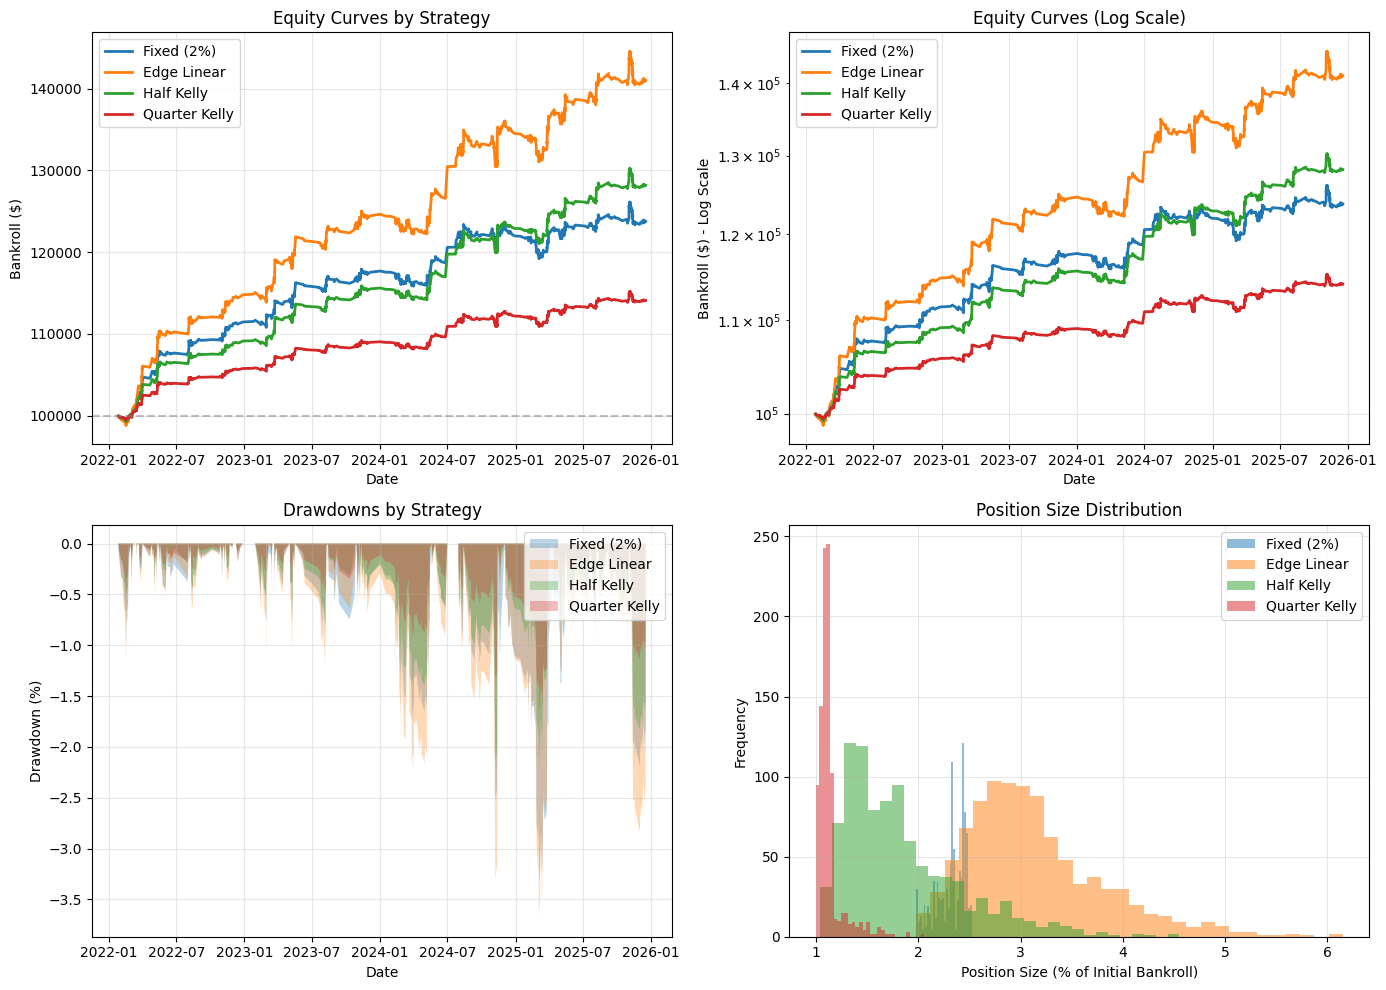

In [8]:
# Plot equity curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Equity curves
ax = axes[0, 0]
for name, result_df in results.items():
    ax.plot(result_df['date'], result_df['bankroll'], label=name, linewidth=2)
ax.axhline(INITIAL_BANKROLL, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Bankroll ($)')
ax.set_title('Equity Curves by Strategy')
ax.legend()
ax.grid(True, alpha=0.3)

# Log equity curves
ax = axes[0, 1]
for name, result_df in results.items():
    ax.plot(result_df['date'], result_df['bankroll'], label=name, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Bankroll ($) - Log Scale')
ax.set_title('Equity Curves (Log Scale)')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Drawdowns
ax = axes[1, 0]
for name, result_df in results.items():
    df_temp = result_df.copy()
    df_temp['high_water'] = df_temp['bankroll'].cummax()
    df_temp['drawdown'] = (df_temp['bankroll'] - df_temp['high_water']) / df_temp['high_water']
    ax.fill_between(df_temp['date'], 0, df_temp['drawdown'] * 100, alpha=0.3, label=name)
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown (%)')
ax.set_title('Drawdowns by Strategy')
ax.legend()
ax.grid(True, alpha=0.3)

# Position size distribution
ax = axes[1, 1]
for name, result_df in results.items():
    sizes_pct = result_df['position_size'] / INITIAL_BANKROLL * 100
    ax.hist(sizes_pct, bins=30, alpha=0.5, label=name)
ax.set_xlabel('Position Size (% of Initial Bankroll)')
ax.set_ylabel('Frequency')
ax.set_title('Position Size Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Kelly Sensitivity Analysis

In [9]:
# Test different Kelly fractions
kelly_fractions = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]

kelly_results = []
for frac in kelly_fractions:
    def kelly_func(row, bankroll, base_risk_pct, kelly_mult=frac):
        edge = row['edge']
        historical_std = 0.12
        kelly = compute_edge_based_kelly(
            pred_q75=row['pred_q75'],
            implied_move=row['implied_move'],
            spread_cost=SPREAD_COST,
            historical_std=historical_std,
            kelly_mult=kelly_mult
        )
        return bankroll * base_risk_pct * kelly
    
    # Create closure with correct fraction
    def make_kelly_func(mult):
        def f(row, bankroll, base_risk_pct):
            edge = row['edge']
            historical_std = 0.12
            kelly = compute_edge_based_kelly(
                pred_q75=row['pred_q75'],
                implied_move=row['implied_move'],
                spread_cost=SPREAD_COST,
                historical_std=historical_std,
                kelly_mult=mult
            )
            return bankroll * base_risk_pct * kelly
        return f
    
    result = simulate_sizing_strategy(
        trades, make_kelly_func(frac),
        initial_bankroll=INITIAL_BANKROLL,
        base_risk_pct=BASE_RISK,
        max_daily_trades=5
    )
    
    m = compute_metrics(result, INITIAL_BANKROLL)
    m['kelly_fraction'] = frac
    kelly_results.append(m)

kelly_df = pd.DataFrame(kelly_results)
print("=== Kelly Fraction Sensitivity ===")
print(kelly_df[['kelly_fraction', 'total_return', 'max_drawdown', 'sharpe', 'cagr']].to_string(
    index=False,
    formatters={
        'kelly_fraction': '{:.2f}'.format,
        'total_return': '{:.1%}'.format,
        'max_drawdown': '{:.1%}'.format,
        'sharpe': '{:.2f}'.format,
        'cagr': '{:.1%}'.format,
    }
))

=== Kelly Fraction Sensitivity ===
kelly_fraction total_return max_drawdown sharpe  cagr
          0.10        11.3%        -1.7%   1.34  2.8%
          0.25        14.1%        -1.6%   1.45  3.4%
          0.50        28.2%        -2.2%   1.56  6.6%
          0.75        44.9%        -3.2%   1.53 10.0%
          1.00        62.4%        -4.3%   1.49 13.3%
          1.50        80.2%        -6.4%   1.38 16.3%
          2.00        86.5%        -8.6%   1.25 17.3%


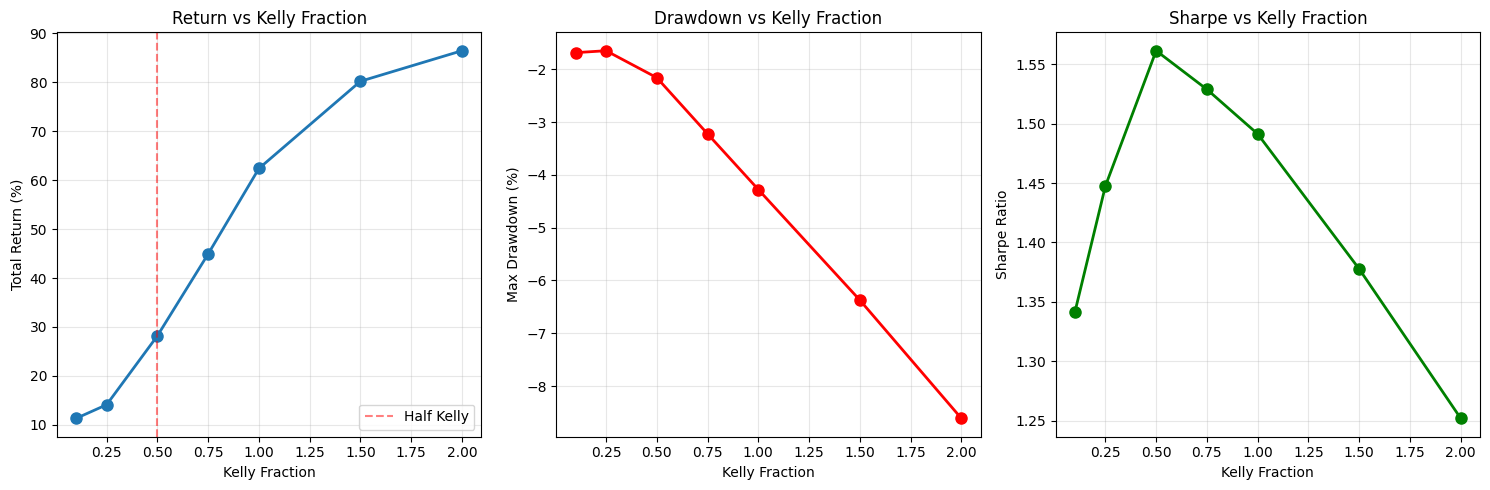

In [10]:
# Plot Kelly sensitivity
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
ax.plot(kelly_df['kelly_fraction'], kelly_df['total_return'] * 100, 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Kelly Fraction')
ax.set_ylabel('Total Return (%)')
ax.set_title('Return vs Kelly Fraction')
ax.grid(True, alpha=0.3)
ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Half Kelly')
ax.legend()

ax = axes[1]
ax.plot(kelly_df['kelly_fraction'], kelly_df['max_drawdown'] * 100, 'o-', linewidth=2, markersize=8, color='red')
ax.set_xlabel('Kelly Fraction')
ax.set_ylabel('Max Drawdown (%)')
ax.set_title('Drawdown vs Kelly Fraction')
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.plot(kelly_df['kelly_fraction'], kelly_df['sharpe'], 'o-', linewidth=2, markersize=8, color='green')
ax.set_xlabel('Kelly Fraction')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe vs Kelly Fraction')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Risk-Adjusted Comparison

In [11]:
# Return per unit of drawdown
print("=== Risk-Adjusted Metrics ===")
print("\nReturn / Max Drawdown (higher is better):")

for name, m in metrics.items():
    if m['max_drawdown'] != 0:
        ratio = m['total_return'] / abs(m['max_drawdown'])
        print(f"  {name}: {ratio:.2f}")

print("\nCAGR / Max Drawdown:")
for name, m in metrics.items():
    if m['max_drawdown'] != 0:
        ratio = m['cagr'] / abs(m['max_drawdown'])
        print(f"  {name}: {ratio:.2f}")

=== Risk-Adjusted Metrics ===

Return / Max Drawdown (higher is better):
  Fixed (2%): 7.09
  Edge Linear: 11.14
  Half Kelly: 13.07
  Quarter Kelly: 8.56

CAGR / Max Drawdown:
  Fixed (2%): 1.68
  Edge Linear: 2.50
  Half Kelly: 3.05
  Quarter Kelly: 2.09


In [12]:
# Analyze position sizing by edge bucket
print("\n=== Position Sizing by Edge Bucket (Half Kelly) ===")

hk_result = results['Half Kelly'].copy()
hk_result['edge_bucket'] = pd.cut(
    hk_result['edge'],
    bins=[0, 0.08, 0.10, 0.15, 0.20, 1.0],
    labels=['6-8%', '8-10%', '10-15%', '15-20%', '20%+']
)

bucket_stats = hk_result.groupby('edge_bucket', observed=True).agg({
    'position_size': ['mean', 'std'],
    'pnl_dollars': ['mean', 'sum', 'count'],
    'pnl_pct': 'mean',
}).round(0)

bucket_stats.columns = ['Avg Size $', 'Std Size $', 'Avg P&L $', 'Total P&L $', 'N Trades', 'Avg P&L %']
bucket_stats['Avg Size %'] = (bucket_stats['Avg Size $'] / INITIAL_BANKROLL * 100).round(1)
print(bucket_stats)


=== Position Sizing by Edge Bucket (Half Kelly) ===
             Avg Size $  Std Size $  Avg P&L $  Total P&L $  N Trades  \
edge_bucket                                                             
6-8%             1538.0       255.0        5.0       3026.0       669   
8-10%            2337.0       301.0       36.0       7585.0       213   
10-15%           3254.0       438.0      258.0      17574.0        68   

             Avg P&L %  Avg Size %  
edge_bucket                         
6-8%               0.0         1.5  
8-10%              0.0         2.3  
10-15%             0.0         3.3  


## 7. Practical Recommendations

In [13]:
# Simple tier-based sizing (practical implementation)
def tiered_sizing(row, bankroll, base_risk_pct):
    """
    Simple tier-based sizing:
    - Edge 6-8%: 1x base
    - Edge 8-10%: 1.5x base
    - Edge 10-15%: 2x base
    - Edge 15%+: 2.5x base
    """
    edge = row['edge']
    
    if edge < 0.06:
        return 0
    elif edge < 0.08:
        mult = 1.0
    elif edge < 0.10:
        mult = 1.5
    elif edge < 0.15:
        mult = 2.0
    else:
        mult = 2.5
    
    return bankroll * base_risk_pct * mult

# Test tiered sizing
tiered_result = simulate_sizing_strategy(
    trades, tiered_sizing,
    initial_bankroll=INITIAL_BANKROLL,
    base_risk_pct=BASE_RISK,
    max_daily_trades=5
)

tiered_metrics = compute_metrics(tiered_result, INITIAL_BANKROLL)

print("=== Tiered Sizing Results ===")
for key, val in tiered_metrics.items():
    if isinstance(val, float):
        if 'pct' in key or 'return' in key or 'drawdown' in key or 'rate' in key or 'cagr' in key:
            print(f"  {key}: {val:.1%}")
        else:
            print(f"  {key}: {val:.2f}")
    else:
        print(f"  {key}: {val}")

=== Tiered Sizing Results ===
  n_trades: 950
  total_return: 41.5%
  cagr: 9.3%
  max_drawdown: -3.3%
  sharpe: 1.51
  win_rate: 43.4%
  avg_position_pct: 2.9%
  final_bankroll: 141498.17


In [14]:
# Summary comparison
print("\n" + "="*70)
print("SUMMARY: Position Sizing Recommendations")
print("="*70)

print("""
1. FIXED SIZING (2% per trade)
   - Simplest to implement
   - Consistent risk per trade
   - Doesn't capitalize on high-edge opportunities

2. HALF KELLY
   - Good balance of growth and risk control
   - Sizes up on high-edge trades
   - Requires accurate edge estimation

3. QUARTER KELLY
   - More conservative
   - Lower drawdowns
   - Better for uncertain edge estimates

4. TIERED SIZING (RECOMMENDED)
   - Simple to implement (4 tiers)
   - Captures most of Kelly benefit
   - Easier to explain and audit
   
   Tiers:
   - Edge 6-8%:  1.0x base risk (2%)
   - Edge 8-10%: 1.5x base risk (3%)
   - Edge 10-15%: 2.0x base risk (4%)
   - Edge 15%+:  2.5x base risk (5%)

CAUTION:
- These results assume edge estimates are accurate
- Model may be overfit to historical data
- Start with fixed sizing until edge is validated in paper trading
""")


SUMMARY: Position Sizing Recommendations

1. FIXED SIZING (2% per trade)
   - Simplest to implement
   - Consistent risk per trade
   - Doesn't capitalize on high-edge opportunities

2. HALF KELLY
   - Good balance of growth and risk control
   - Sizes up on high-edge trades
   - Requires accurate edge estimation

3. QUARTER KELLY
   - More conservative
   - Lower drawdowns
   - Better for uncertain edge estimates

4. TIERED SIZING (RECOMMENDED)
   - Simple to implement (4 tiers)
   - Captures most of Kelly benefit
   - Easier to explain and audit
   
   Tiers:
   - Edge 6-8%:  1.0x base risk (2%)
   - Edge 8-10%: 1.5x base risk (3%)
   - Edge 10-15%: 2.0x base risk (4%)
   - Edge 15%+:  2.5x base risk (5%)

CAUTION:
- These results assume edge estimates are accurate
- Model may be overfit to historical data
- Start with fixed sizing until edge is validated in paper trading



In [15]:
# Final comparison table
all_metrics = metrics.copy()
all_metrics['Tiered'] = tiered_metrics

comparison = pd.DataFrame(all_metrics).T
comparison = comparison[['n_trades', 'total_return', 'cagr', 'max_drawdown', 'sharpe', 'win_rate', 'avg_position_pct']]

print("\n=== Final Strategy Comparison ===")
print(comparison.to_string(formatters={
    'n_trades': '{:.0f}'.format,
    'total_return': '{:.1%}'.format,
    'cagr': '{:.1%}'.format,
    'max_drawdown': '{:.1%}'.format,
    'sharpe': '{:.2f}'.format,
    'win_rate': '{:.1%}'.format,
    'avg_position_pct': '{:.1%}'.format,
}))


=== Final Strategy Comparison ===
              n_trades total_return cagr max_drawdown sharpe win_rate avg_position_pct
Fixed (2%)         950        23.8% 5.6%        -3.4%   1.31    43.4%             2.3%
Edge Linear        950        41.0% 9.2%        -3.7%   1.46    43.4%             3.1%
Half Kelly         950        28.2% 6.6%        -2.2%   1.56    43.4%             1.8%
Quarter Kelly      950        14.1% 3.4%        -1.6%   1.45    43.4%             1.1%
Tiered             950        41.5% 9.3%        -3.3%   1.51    43.4%             2.9%
